#### <hr>
<h2>> LOAD IN THE LIBRARIES AND DATA</h2>
<hr>

In [186]:
# Basic 

import os
import random
import re
import math
import time
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join

# Scikit-learn

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score

# Deep Learning

from tqdm import tqdm
from tqdm.keras import TqdmCallback
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
import efficientnet.tfkeras as efn
from keras import layers
from keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam

# Visualization

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly
import plotly.express as px
from plotly.tools import FigureFactory as FF
from plotly.offline import iplot
import seaborn as sns
%matplotlib inline

# Misc

import streamlit as st
from PIL import Image
import cufflinks
import cv2 as cv
import warnings
warnings.filterwarnings('ignore')

In [231]:
# Setting file paths for our notebook:

base_path = r'C:\Users\HIMANSHU\Downloads\Melanoma jpg'

train_img_path = r'C:\Users\HIMANSHU\Downloads\Melanoma jpg\train'
train_images = [f for f in listdir(train_img_path) if isfile(join(train_img_path, f))]

test_img_path = r'C:\Users\HIMANSHU\Downloads\Melanoma jpg\test'
test_images = [f for f in listdir(test_img_path) if isfile(join(test_img_path, f))]

img_stats_path = r'C:\Users\HIMANSHU\Downloads\Melanoma Dataset'

In [232]:
# Loading train and test data.

train = pd.read_csv(os.path.join(base_path, 'train.csv'))
test = pd.read_csv(os.path.join(base_path, 'test.csv'))
sample = pd.read_csv(os.path.join(base_path, 'sample_submission.csv'))

<hr>
<h1>> EXPLORATORY DATA ANALYSIS </h1>
<hr>

In [233]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [234]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [191]:
# # Removing unnecessary columns:

# train.drop(columns=['tfrecord', 'width', 'height'], inplace=True)
# test.drop(columns=['width', 'height'], inplace=True)

In [235]:
# Renaming train/test columns:

train.columns = [
    'img_name', 'id', 'sex', 'age', 'location', 'diagnosis',
    'benign_malignant', 'target'
]
test.columns = ['img_name', 'id', 'sex', 'age', 'location']

In [236]:
train.head()

,img_name,id,sex,age,location,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [237]:
test.head()

,img_name,id,sex,age,location
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [238]:
# Lets take a look at columns

print('Train Data columns: \n')
print(train.columns)
print('')
print('Test Data columns: \n')
print(test.columns)

Train Data columns: 

Index(['img_name', 'id', 'sex', 'age', 'location', 'diagnosis',
       'benign_malignant', 'target'],
      dtype='object')

Test Data columns: 

Index(['img_name', 'id', 'sex', 'age', 'location'], dtype='object')


<hr>
<h2> > Description of Dataset :-</h2>
<hr>
<h4>image name -> the filename of specific image for the train set</h4>
<h4>patient_id -> identifies the unique patient</h4>
<h4>sex -> gender of the patient</h4>
<h4>age_approx -> approx age of the patient at time of scanning</h4>
<h4>anatom_site_general_challenge -> location of the scan site</h4>
<h4>diagnosis -> information about the diagnosis</h4>
<h4>benign_malignant - indicates scan result if it's malignant or benign</h4>
<h4>target -> same as above but better for modelling since it's binary</h4>
<hr>

In [239]:
# Data-types

print('Train Data types: \n')
print(train.dtypes)

Train Data types: 

img_name             object
id                   object
sex                  object
age                 float64
location             object
diagnosis            object
benign_malignant     object
target                int64
dtype: object


In [240]:
# Brief description of data

train.describe(include='all')

,img_name,id,sex,age,location,diagnosis,benign_malignant,target
count,33126,33126,33061,33058.000000,32599,33126,33126,33126.000000
unique,33126,2056,2,NaN,6,9,2,NaN
top,ISIC_8595693,IP_4938382,male,NaN,torso,unknown,benign,NaN
freq,1,115,17080,NaN,16845,27124,32542,NaN
mean,NaN,NaN,NaN,48.870016,NaN,NaN,NaN,0.017630
std,NaN,NaN,NaN,14.380360,NaN,NaN,NaN,0.131603
min,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,40.000000,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,50.000000,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,60.000000,NaN,NaN,NaN,0.000000


In [241]:
train['sex'].value_counts()

male      17080
female    15981
Name: sex, dtype: int64

In [242]:
train['age'].value_counts()

45.0    4466
50.0    4270
55.0    3824
40.0    3576
60.0    3240
35.0    2850
65.0    2527
30.0    2358
70.0    1968
25.0    1544
75.0     981
20.0     655
80.0     419
85.0     149
15.0     132
90.0      80
10.0      17
0.0        2
Name: age, dtype: int64

In [243]:
# Different classes for 'diagnosis'

train['diagnosis'].value_counts()

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
cafe-au-lait macule                       1
atypical melanocytic proliferation        1
Name: diagnosis, dtype: int64

In [244]:
train['location'].value_counts()

torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
palms/soles          375
oral/genital         124
Name: location, dtype: int64

In [245]:
train['benign_malignant'].value_counts()

benign       32542
malignant      584
Name: benign_malignant, dtype: int64

<hr>
<h2>ANALYSIS :-</h2>
<ol>
    <li>'img_name' = Names of images, single patient can have multiple images (33,126)
    <li>'id' = ID, unqiue for all (2056)
    <li>'sex' = Males are more than Women (2)
    <li>'age' = Mean age is 48.87, most are between 40 and 60
    <li>'location' = Mainly on Torso (7)
    <li>'diagnosis' = There are 10 different classes
    <li>'benign_malignant' = Whether Benign or Malignant, most are benign (2)
    <li>'target' = Same as above, just binary (2)
    <li>This is an highly imbalanced dataset, only 0.017% malignant cases.
<\ol>
<hr>

In [203]:
# test.describe(include='all')

<hr>
<h2>> MISSING VALUES</h2>
<hr>

In [246]:
# Checking for null values

print('Null values in Train: ')
print(train.isnull().sum())
print('')
print('Null values in Test: ')
print(test.isnull().sum())

Null values in Train: 
img_name              0
id                    0
sex                  65
age                  68
location            527
diagnosis             0
benign_malignant      0
target                0
dtype: int64

Null values in Test: 
img_name      0
id            0
sex           0
age           0
location    351
dtype: int64


<hr>
<h3>We have small portion of missing values for age and sex I think there is no harm if we impute them with the most frequent ones, meanwhile body parts missing on both datasets, we better be set 'unknown' for missing values for this one </h3>
<hr>

Text(0.5, 1.0, 'Test Data Missing Values')

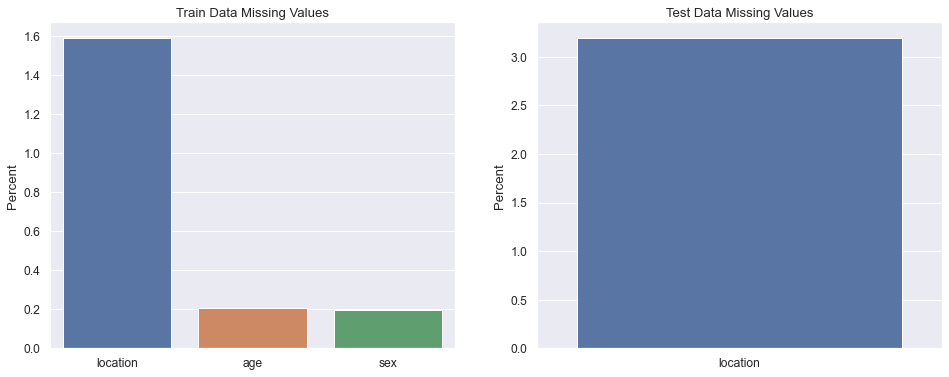

In [247]:
# Checking missing values:

def missing_percentage(df):

    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
               100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                     100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])


missing_train = missing_percentage(train)
missing_test = missing_percentage(test)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=missing_train.index,
            y='Percent',
            data=missing_train,
            ax=ax[0])

sns.barplot(x=missing_test.index,
            y='Percent',
            data=missing_test,
            ax=ax[1])

ax[0].set_title('Train Data Missing Values')
ax[1].set_title('Test Data Missing Values')

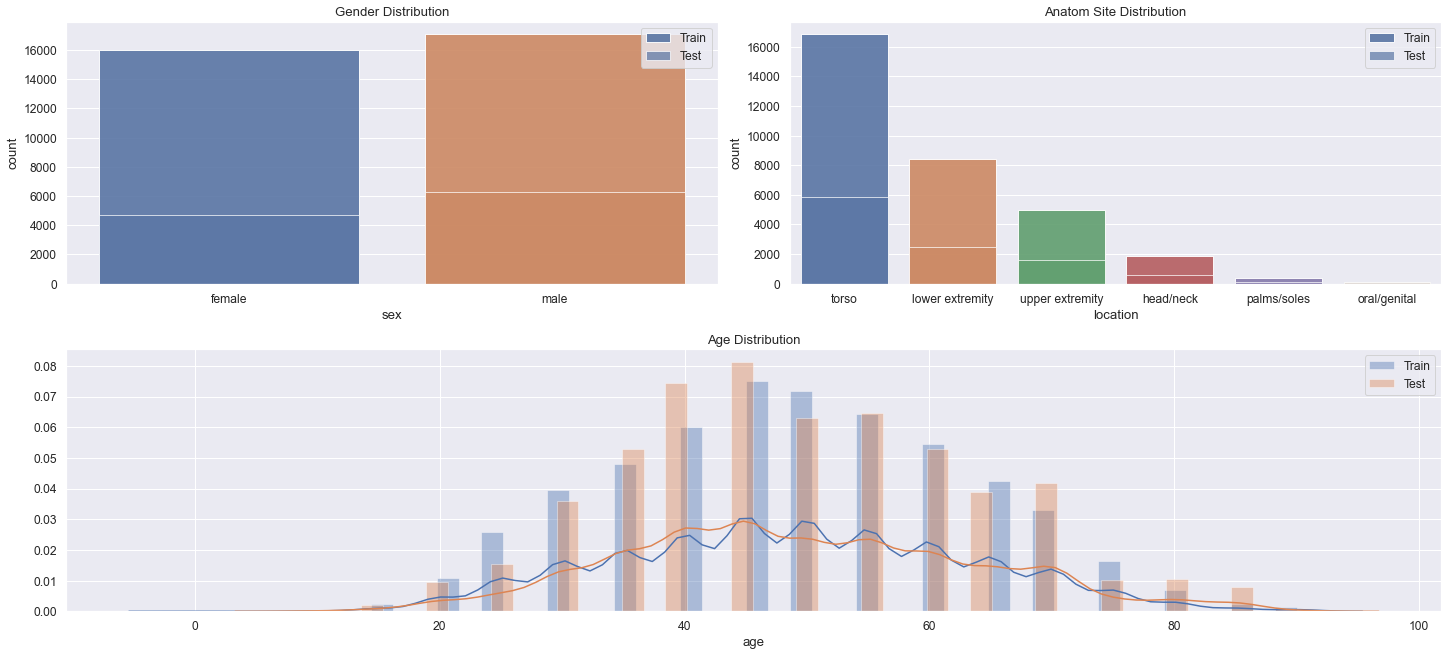

In [248]:
# Creating a customized chart and giving in figsize etc.

fig = plt.figure(constrained_layout=True, figsize=(20, 9))

# Creating a grid:

grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])

# Set the title.

ax1.set_title('Gender Distribution')

sns.countplot(train.sex.sort_values(ignore_index=True),
              alpha=0.9,
              ax=ax1,
              
              label='Train')
sns.countplot(test.sex.sort_values(ignore_index=True),
              alpha=0.7,
              ax=ax1,
              
              label='Test')
ax1.legend()

# Customizing the second grid.

ax2 = fig.add_subplot(grid[0, 2:])

# Plot the countplot.

sns.countplot(train.location,
              alpha=0.9,
              ax=ax2,
            
              label='Train',
              order=train['location'].value_counts().index)
sns.countplot(test.location,
              alpha=0.7,
              ax=ax2,
              
              label='Test',
              order=test['location'].value_counts().index), ax2.set_title(
                  'Anatom Site Distribution')

ax2.legend()

# Customizing the third grid.

ax3 = fig.add_subplot(grid[1, :])

# Set the title.

ax3.set_title('Age Distribution')

# Plot the histogram.

sns.distplot(train.age, ax=ax3, label='Train')
sns.distplot(test.age, ax=ax3, label='Test')

ax3.legend()

plt.show()

In [249]:
# Filling missing anatom site values with 'unknown' tag:

for df in [train, test]:
    df['location'].fillna('unknown', inplace=True)

In [250]:
# Filling age and sex with appropriate values.

train['sex'].fillna(train['sex'].mode()[0], inplace=True)

train['age'].fillna(train['age'].median(), inplace=True)

In [251]:
# Checking missing value counts:

print(
    f'Train missing value count: {train.isnull().sum().sum()}\nTest missing value count: {train.isnull().sum().sum()}'
)

Train missing value count: 0
Test missing value count: 0


In [252]:
train

,img_name,id,sex,age,location,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0


In [253]:
test

,img_name,id,sex,age,location
0,ISIC_0052060,IP_3579794,male,70.0,unknown
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity
...,...,...,...,...,...
10977,ISIC_9992485,IP_4152479,male,40.0,torso
10978,ISIC_9996992,IP_4890115,male,35.0,torso
10979,ISIC_9997917,IP_2852390,male,25.0,upper extremity
10980,ISIC_9998234,IP_8861963,male,65.0,lower extremity


In [254]:
# Train data:

cntstr = train.location.value_counts().rename_axis('location').reset_index(
    name='count')

fig = px.treemap(cntstr,
                 path=['location'],
                 values='count',
                 color='count',
                 title='Scans by Anatom Site General Challenge - Train Data')

fig.update_traces(textinfo='label+percent entry')
fig.show()

In [255]:
# Test data:

cntste = test.location.value_counts().rename_axis('location').reset_index(
    name='count')

fig = px.treemap(cntste,
                 path=['location'],
                 values='count',
                 color='count',
                 title='Scans by Anatom Site General Challenge - Test Data')

fig.update_traces(textinfo='label+percent entry')
fig.show()

<hr>
<h2>> Body Part Ratio by Gender and Target</h2>
<hr>

2020-10-20 07:44:49.524 WARNING matplotlib.legend: No handles with labels found to put in legend.


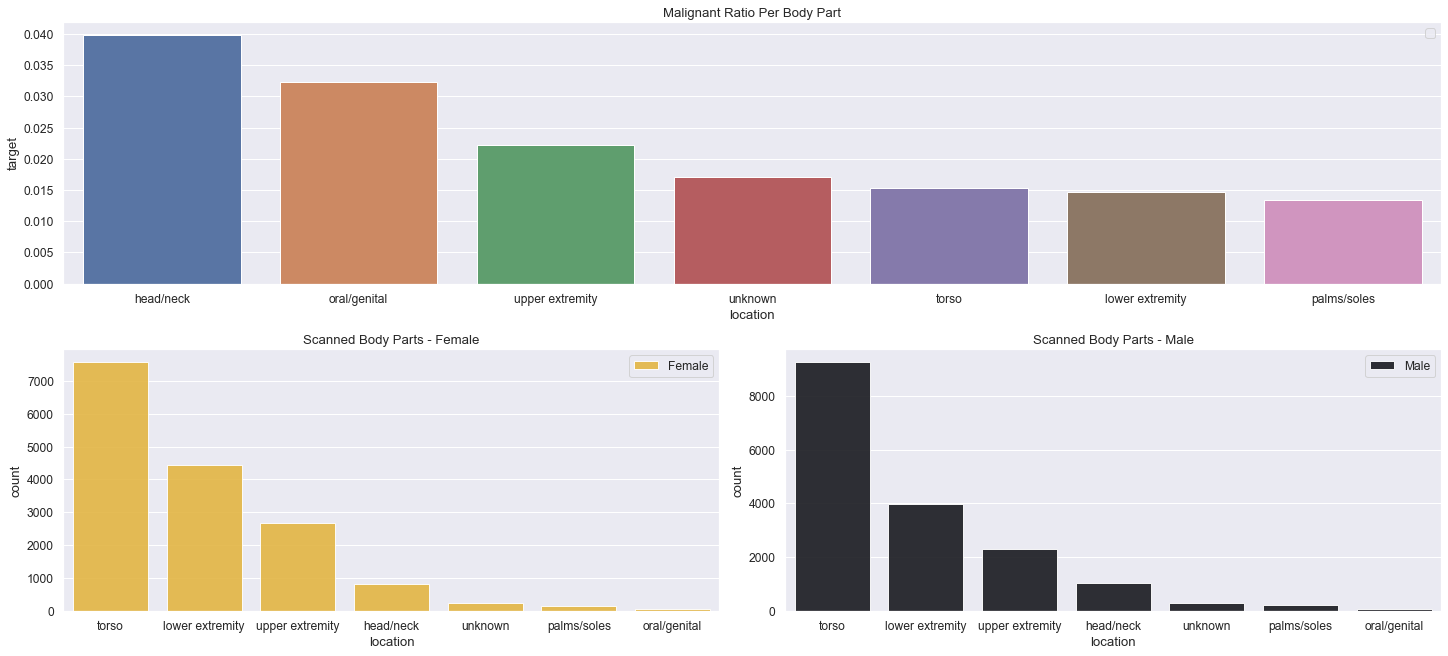

In [256]:
# Creating a customized chart and giving in figsize etc.

fig = plt.figure(constrained_layout=True, figsize=(20, 9))
# Creating a grid
grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

# Customizing the first grid.

ax1 = fig.add_subplot(grid[1, :2])
# Set the title.
ax1.set_title('Scanned Body Parts - Female')

# Plot:

sns.countplot(
    train[train['sex'] == 'female'].location.sort_values(ignore_index=True),
    alpha=0.9,
    ax=ax1,
    color='#fdc029',
    label='Female',
    order=train['location'].value_counts().index)
ax1.legend()

# Customizing the second grid.

ax2 = fig.add_subplot(grid[1, 2:])

# Set the title.

ax2.set_title('Scanned Body Parts - Male')

# Plot.

sns.countplot(
    train[train['sex'] == 'male'].location.sort_values(ignore_index=True),
    alpha=0.9,
    ax=ax2,
    color='#171820',
    label='Male',
    order=train['location'].value_counts().index)

ax2.legend()

# Customizing the third grid.

ax3 = fig.add_subplot(grid[0, :])

# Set the title.

ax3.set_title('Malignant Ratio Per Body Part')

# Plot.

loc_freq = train.groupby('location')['target'].mean().sort_values(
    ascending=False)
sns.barplot(x=loc_freq.index, y=loc_freq, ax=ax3)

ax3.legend()

plt.show()

<hr>
<h2>A General Look With Sunburst Chart</h2>
<ul>
<li>Only 2% of our targets are malignant
<li>On malignant images males are dominant with 62%
<li>Gender wise benign images are more balance 52-48% male female ratio
<li>Malignant image scan locations differs based on the patients gender:
<li>Meanwhile the torso is most common location in males it's almost half of the scans meanwhile in females it's 39%
<li>Lower extremity is more common with female scans than males 18% males vs 26% females
<li>Again upper extremity malignant scans is common with females than males (23- 17%)
<li>Benign image scan locations more similar between male and female patients
</ul>
<hr>

In [257]:
# Plotting interactive sunburst:

fig = px.sunburst(data_frame=train,
                  path=['benign_malignant', 'sex', 'location'],
                  color='sex',
                  maxdepth=-1,
                  title='Sunburst Chart Benign/Malignant > Sex > Location')

fig.update_traces(textinfo='label+percent parent')
fig.update_layout(margin=dict(t=0, l=0, r=0, b=0))
fig.show()

<hr>
<h2>Age and Scan Result Relations</h2>

Age looks pretty decent factor on scan result. Getting malignant scan result with elderly age is more possible than young patients. There is spike for both genders after age of 85, if we look distribution of ages there isn't much of 80+ patients and it can be the reason of this spike but we can safely say it's more likely to be malignant scan after age of 60. We see small bump on age 15-20 for females, again it depends on the scan numbers.
<hr>

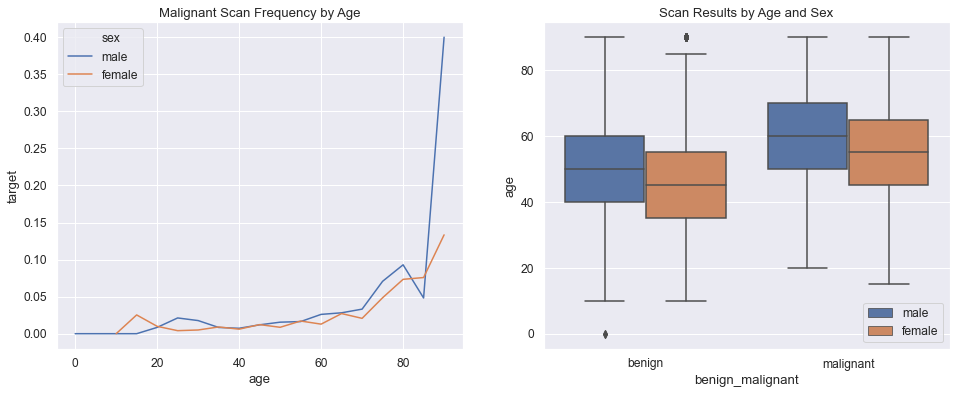

In [258]:
# Plotting age vs sex vs target:

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.lineplot(x='age',
             y='target',
             data=train,
             ax=ax[0],
             hue='sex',
             ci=None)
sns.boxplot(x='benign_malignant',
            y='age',
            data=train,
            ax=ax[1],
            hue='sex')

plt.legend(loc='lower right')

ax[0].set_title('Malignant Scan Frequency by Age')
ax[1].set_title('Scan Results by Age and Sex')

plt.show()


<hr>
<h2>Age Round Two</h2>

Wanted to double check age distributions after our previous observations. Age seems evenly distributed on both train and test datasets, we can see small bumps at age 75+ and around 40, these worth investigating.

We can see again older people are more likely to get malignant scan results. One last thing about age distributions, we see more female patients in younger ages this trend changes with the older patients.
<hr>

2020-10-20 07:44:58.100 WARNING matplotlib.legend: No handles with labels found to put in legend.


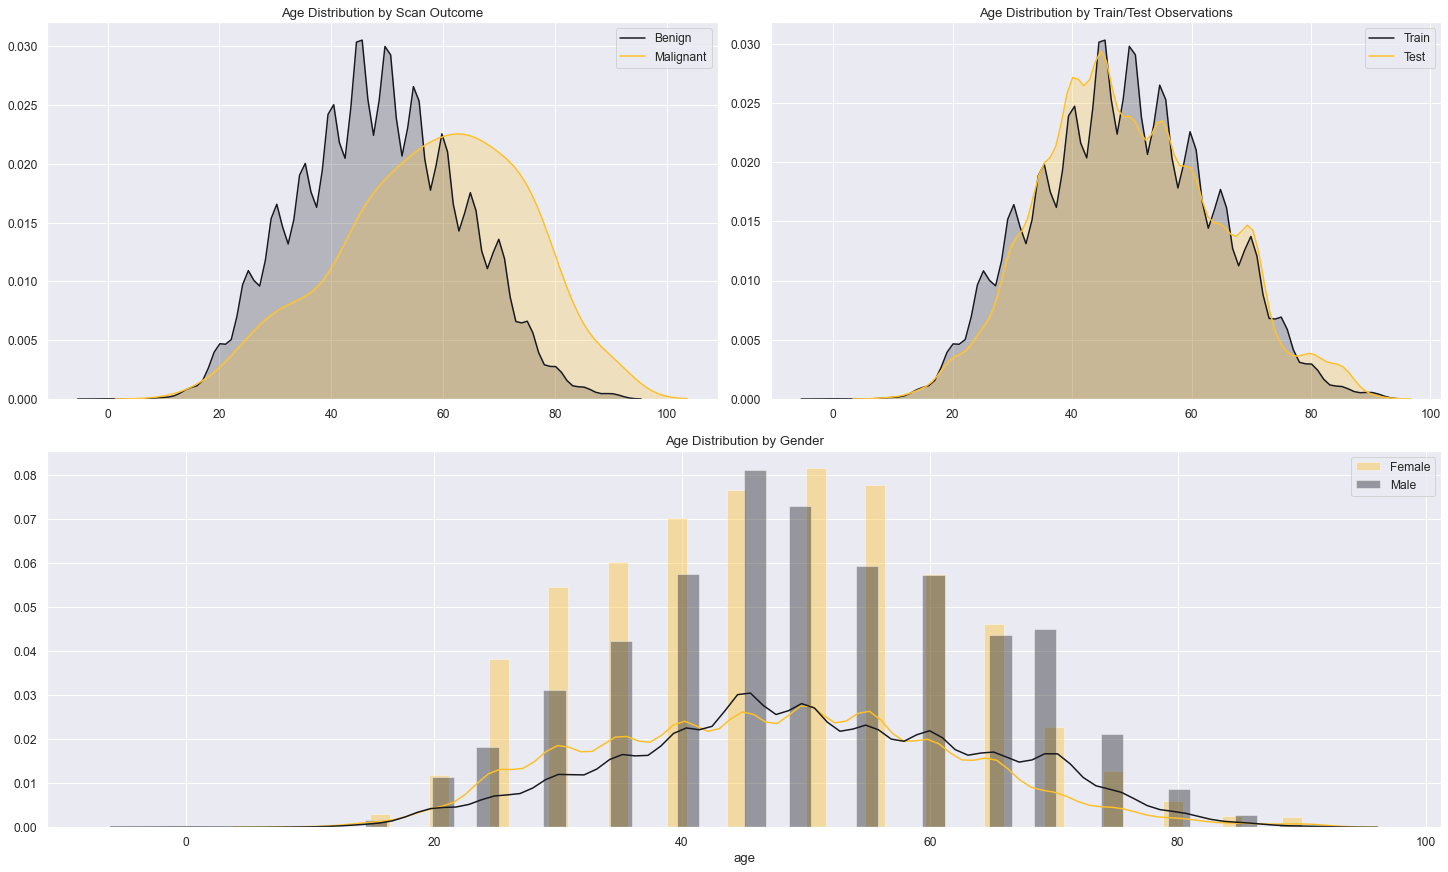

In [259]:
# Creating a customized chart and giving in figsize etc.

# Plotting age dist vs target and age dist vs datasets

fig = plt.figure(constrained_layout=True, figsize=(20, 12))

# Creating a grid

grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

# Customizing the first grid.

ax1 = fig.add_subplot(grid[0, :2])

# Set the title.

ax1.set_title('Age Distribution by Scan Outcome')

# Plot

ax1.legend()

sns.kdeplot(train[train['target'] == 0]['age'],
            shade=True,
            ax=ax1,
            color='#171820',
            label='Benign')
sns.kdeplot(train[train['target'] == 1]['age'],
            shade=True,
            ax=ax1,
            color='#fdc029',
            label='Malignant')

# Customizing second grid.

ax2 = fig.add_subplot(grid[0, 2:])

# Set the title.

ax2.set_title('Age Distribution by Train/Test Observations')

# Plot.

sns.kdeplot(train.age, label='Train', shade=True, ax=ax2, color='#171820')
sns.kdeplot(test.age, label='Test', shade=True, ax=ax2, color='#fdc029')

ax2.legend()

# Customizing third grid.

ax3 = fig.add_subplot(grid[1, :])

# Set the title.

ax3.set_title('Age Distribution by Gender')

# Plot

sns.distplot(train[train.sex == 'female'].age,
             ax=ax3,
             label='Female',
             color='#fdc029')
sns.distplot(train[train.sex == 'male'].age,
             ax=ax3,
             label='Male',
             color='#171820')
ax3.legend()

plt.show()

<hr>
<h2>Unique Patients and Their Scan Images</h2>

It looks like we have multiple scan images per patient, actual unique patient counts are much lower than images on both datasets. We can get more information about patients age like when he had his first scan and his last scan. We can get interesting insights like:

Most of the malignant results are found around first 20 scans. Of course there can be control scans after the diagnosis...
Scan numbers are similar in first 100 scans but we have 200+ scan images for one particular patient in dataset, it's pretty interesting since we don't have this case in our training data. We should be careful about this and it can effect our model.
Most of the malignant cases are under 20 images but in general we can say it's more likely to be malignant result if there are more scan images
<hr>

In [260]:
print(
    f'Number of unique Patient ID\'s in train set: {train.id.nunique()}, Total: {train.id.count()}\nNumber of unique Patient ID\'s in test set: {test.id.nunique()}, Total: {test.id.count()}'
)

Number of unique Patient ID's in train set: 2056, Total: 33126
Number of unique Patient ID's in test set: 690, Total: 10982


In [261]:
train['age_min'] = train['id'].map(train.groupby(['id']).age.min())
train['age_max'] = train['id'].map(train.groupby(['id']).age.max())

test['age_min'] = test['id'].map(test.groupby(['id']).age.min())
test['age_max'] = test['id'].map(test.groupby(['id']).age.max())

In [262]:
train['n_images'] = train.id.map(train.groupby(['id']).img_name.count())
test['n_images'] = test.id.map(test.groupby(['id']).img_name.count())

In [263]:
train

,img_name,id,sex,age,location,diagnosis,benign_malignant,target,age_min,age_max,n_images
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,45.0,45.0,115
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,45.0,45.0,24
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,50.0,55.0,5
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,40.0,45.0,22
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,55.0,55.0,20
...,...,...,...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0,45.0,50.0,36
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0,65.0,65.0,33
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0,15.0,20.0,55
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0,35.0,50.0,29


In [264]:
test

,img_name,id,sex,age,location,age_min,age_max,n_images
0,ISIC_0052060,IP_3579794,male,70.0,unknown,70.0,70.0,240
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,40.0,40.0,46
2,ISIC_0058510,IP_7960270,female,55.0,torso,55.0,55.0,28
3,ISIC_0073313,IP_6375035,female,50.0,torso,50.0,50.0,38
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,40.0,65.0,29
...,...,...,...,...,...,...,...,...
10977,ISIC_9992485,IP_4152479,male,40.0,torso,40.0,50.0,9
10978,ISIC_9996992,IP_4890115,male,35.0,torso,35.0,40.0,62
10979,ISIC_9997917,IP_2852390,male,25.0,upper extremity,25.0,45.0,33
10980,ISIC_9998234,IP_8861963,male,65.0,lower extremity,65.0,65.0,25


2020-10-20 07:47:32.861 WARNING matplotlib.legend: No handles with labels found to put in legend.


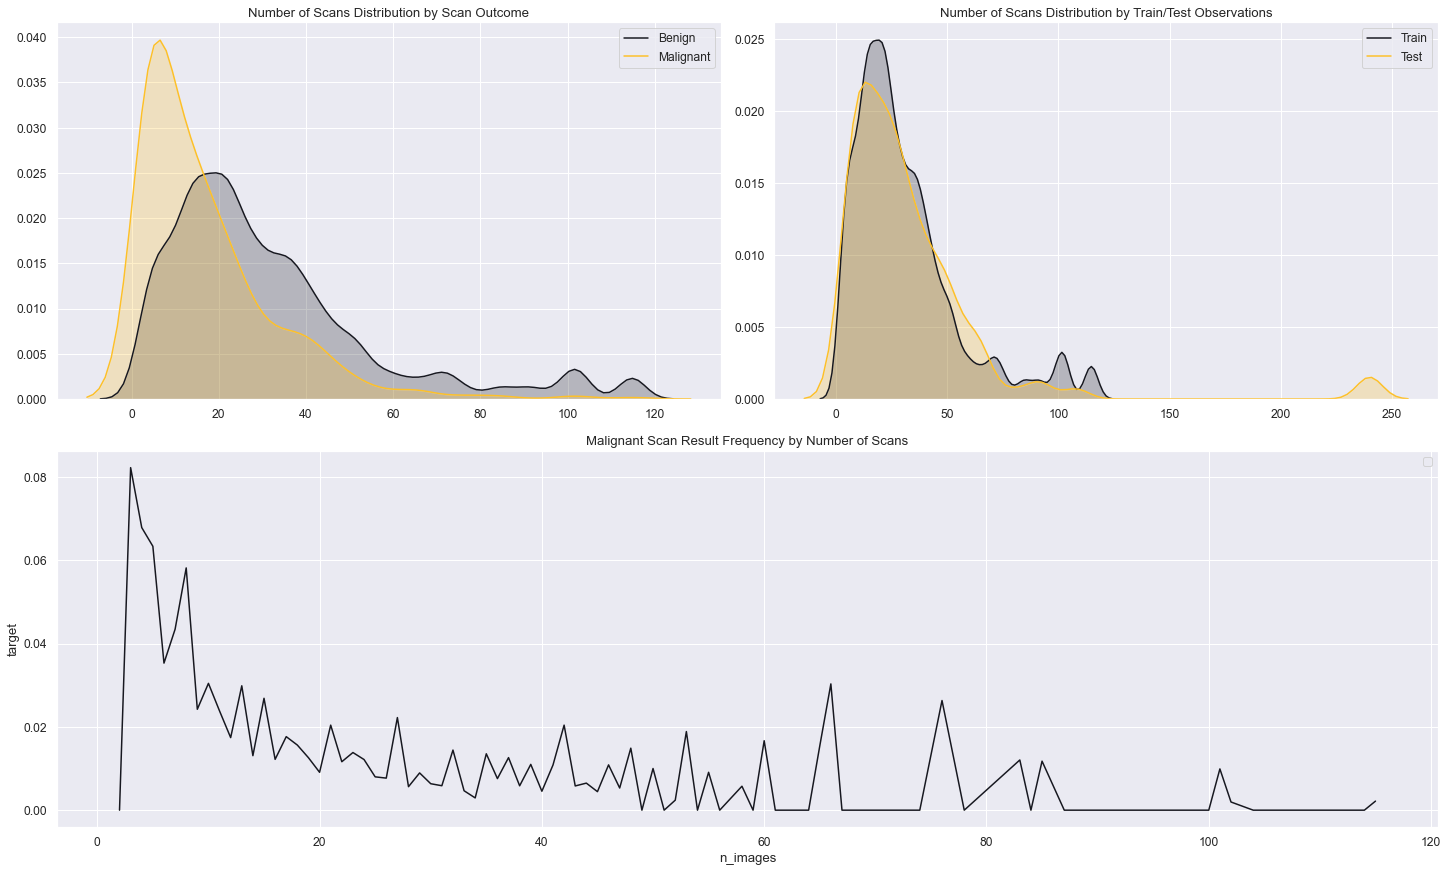

In [265]:
# Creating a customized chart and giving in figsize etc.

fig = plt.figure(constrained_layout=True, figsize=(20, 12))

# Creating a grid

grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

# Customizing the first grid.

ax1 = fig.add_subplot(grid[0, :2])

# Set the title.

ax1.set_title('Number of Scans Distribution by Scan Outcome')

# Plot

sns.kdeplot(train[train['target'] == 0]['n_images'],
            shade=True,
            ax=ax1,
            color='#171820',
            label='Benign')
sns.kdeplot(train[train['target'] == 1]['n_images'],
            shade=True,
            ax=ax1,
            color='#fdc029',
            label='Malignant')

ax1.legend()

# Customizing the second grid.

ax2 = fig.add_subplot(grid[0, 2:])

# Set the title.

ax2.set_title('Number of Scans Distribution by Train/Test Observations')

# Plot

sns.kdeplot(train.n_images, label='Train', shade=True, ax=ax2, color='#171820')
sns.kdeplot(test.n_images, label='Test', shade=True, ax=ax2, color='#fdc029')
ax2.legend()

# Customizing the third grid.

ax3 = fig.add_subplot(grid[1, :])

# Set the title.

ax3.set_title('Malignant Scan Result Frequency by Number of Scans')

# Plot

z = train.groupby('n_images')['target'].mean()
sns.lineplot(x=z.index, y=z, color='#171820', ax=ax3)
ax3.legend()

plt.show()

<hr>
<h2>Diagnosis Distribution</h2>

This part we can't use in our model but it's giving us some insights about this disease so we can inspect that too. You can see the details below:
<hr>

In [266]:
diag = train.diagnosis.value_counts()
fig = px.pie(diag,
             values='diagnosis',
             names=diag.index,
             hole=.4)
fig.update_traces(textinfo='percent+label', pull=0.05)
fig.show()

<hr>
<h2>> Working With Images</h2>
<hr>

In [225]:
# Getting image sizes by using os:

for data, location in zip([train, test], [train_img_path, test_img_path]):
    images = data['img_name'].values
    sizes = np.zeros(images.shape[0])
    for i, path in enumerate(tqdm(images)):
        sizes[i] = os.path.getsize(os.path.join(location, f'{path}.jpg'))

    data['image_size'] = sizes

100%|██████████| 10982/10982 [00:00<00:00, 15287.58it/s]


Examples WITH Melanoma



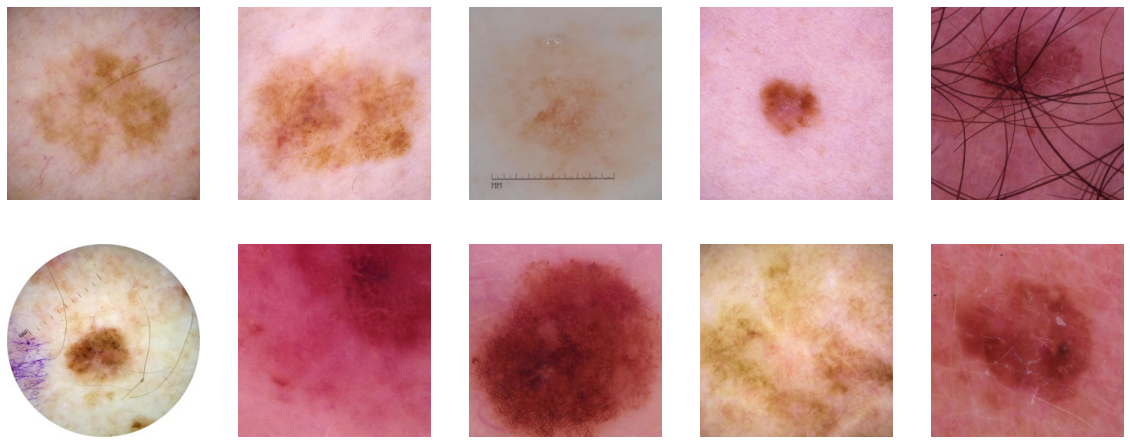


Examples WITHOUT Melanoma


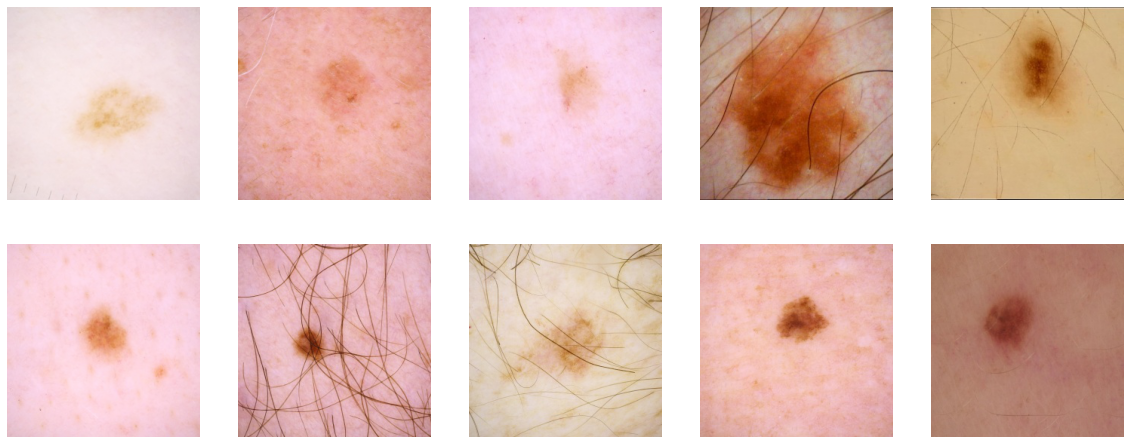

In [226]:
import cv2, pandas as pd, matplotlib.pyplot as plt

train = pd.read_csv(r'C:\Users\HIMANSHU\Downloads\Melanoma jpg\train.csv')
print('Examples WITH Melanoma')
print('')
imgs = train.loc[train.target==1].sample(10).image_name.values
plt.figure(figsize=(20,8))

for i,k in enumerate(imgs):
    img = cv2.imread(r'C:\Users\HIMANSHU\Downloads\Melanoma jpg\train\%s.jpg'%g)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.subplot(2,5,i+1); plt.axis('off')
    plt.imshow(img)
plt.show()

print('')
print('Examples WITHOUT Melanoma')
imgs = train.loc[train.target==0].sample(10).image_name.values
plt.figure(figsize=(20,8))
for i,k in enumerate(imgs):
    img = cv2.imread(r'C:\Users\HIMANSHU\Downloads\Melanoma jpg\train\%s.jpg'%k)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.subplot(2,5,i+1); plt.axis('off')
    plt.imshow(img)
plt.show()

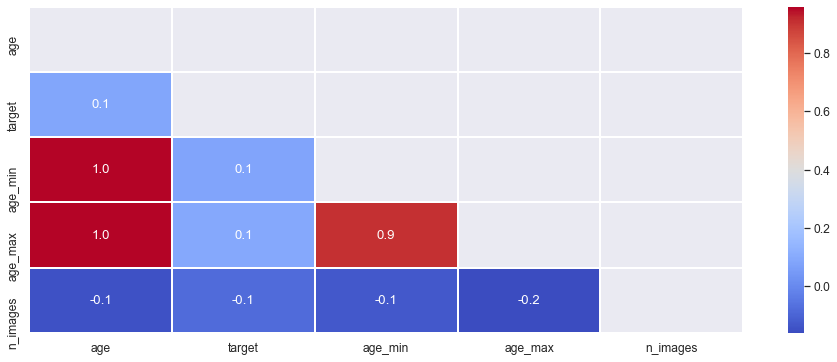

In [267]:
# Display numerical correlations between features on heatmap.

sns.set(font_scale=1.1)
correlation_train = train.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(16, 6))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',            
            mask=mask,
            linewidths=1,
            cbar=True)

plt.show()

<hr>
<h1>> TRAINING MODELS</h1>
<hr>

In [268]:
train.head()

,img_name,id,sex,age,location,diagnosis,benign_malignant,target,age_min,age_max,n_images
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,45.0,45.0,115
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,45.0,45.0,24
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,50.0,55.0,5
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,40.0,45.0,22
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,55.0,55.0,20


In [269]:
test.head()

,img_name,id,sex,age,location,age_min,age_max,n_images
0,ISIC_0052060,IP_3579794,male,70.0,unknown,70.0,70.0,240
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,40.0,40.0,46
2,ISIC_0058510,IP_7960270,female,55.0,torso,55.0,55.0,28
3,ISIC_0073313,IP_6375035,female,50.0,torso,50.0,50.0,38
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,40.0,65.0,29


In [270]:
# getting dummy variables for gender on train set

sex_dummies = pd.get_dummies(train['sex'], prefix='sex')
train = pd.concat([train, sex_dummies], axis=1)

# getting dummy variables for gender on test set

sex_dummies = pd.get_dummies(test['sex'], prefix='sex')
test = pd.concat([test, sex_dummies], axis=1)

# dropping not useful columns

train.drop(['sex','img_name','id','diagnosis','benign_malignant'], axis=1, inplace=True)
test.drop(['sex','img_name','id'], axis=1, inplace=True)

In [271]:
# getting dummy variables for location on train set

anatom_dummies = pd.get_dummies(train['location'], prefix='anatom')
train = pd.concat([train, anatom_dummies], axis=1)

# getting dummy variables for location on test set

anatom_dummies = pd.get_dummies(test['location'], prefix='anatom')
test = pd.concat([test, anatom_dummies], axis=1)

# dropping not useful columns

train.drop('location', axis=1, inplace=True)
test.drop('location', axis=1, inplace=True)

In [272]:
# loading modelling libraries

import xgboost as xgb

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve

In [273]:
# dividing train set and labels for modelling

X = train.drop('target', axis=1)
y = train.target

In [274]:
X.head()

,age,age_min,age_max,n_images,sex_female,sex_male,anatom_head/neck,anatom_lower extremity,anatom_oral/genital,anatom_palms/soles,anatom_torso,anatom_unknown,anatom_upper extremity
0,45.0,45.0,45.0,115,0,1,1,0,0,0,0,0,0
1,45.0,45.0,45.0,24,1,0,0,0,0,0,0,0,1
2,50.0,50.0,55.0,5,1,0,0,1,0,0,0,0,0
3,45.0,40.0,45.0,22,1,0,1,0,0,0,0,0,0
4,55.0,55.0,55.0,20,1,0,0,0,0,0,0,0,1


In [275]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

# Setting Cross-Validation and Hold-out Set

In [276]:
# taking holdout set for validating with stratified y

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

# 5 fold stratify for cv

cv = StratifiedKFold(5, shuffle=True, random_state=42)

In [277]:
# setting model hyperparameters, didn't include fine tuning here because of timing reasons...

xg = xgb.XGBClassifier(
    n_estimators=750,
    min_child_weight=0.81,
    learning_rate=0.025,
    max_depth=2,
    subsample=0.80,
    colsample_bytree=0.42,
    gamma=0.10,
    random_state=42,
    n_jobs=-1,
)

In [278]:
estimators = [xg]

In [279]:
# cross validation scheme

def model_check(X_train, y_train, estimators, cv):
    model_table = pd.DataFrame()

    row_index = 0
    for est in estimators:

        MLA_name = est.__class__.__name__
        model_table.loc[row_index, 'Model Name'] = MLA_name

        cv_results = cross_validate(est,
                                    X_train,
                                    y_train,
                                    cv=cv,
                                    scoring='roc_auc',
                                    return_train_score=True,
                                    n_jobs=-1)

        model_table.loc[row_index,
                        'Train roc Mean'] = cv_results['train_score'].mean()
        model_table.loc[row_index,
                        'Test roc Mean'] = cv_results['test_score'].mean()
        model_table.loc[row_index, 'Test Std'] = cv_results['test_score'].std()
        model_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()

        row_index += 1

    model_table.sort_values(by=['Test roc Mean'],
                            ascending=False,
                            inplace=True)

    return model_table

In [280]:
# display cv results

raw_models = model_check(X_train, y_train, estimators, cv)
display(raw_models)

,Model Name,Train roc Mean,Test roc Mean,Test Std,Time
0,XGBClassifier,0.814966,0.774689,0.012017,6.177002


In [281]:
# fitting train data

xg.fit(X_train, y_train)

# predicting on holdout set
validation = xg.predict_proba(X_test)[:, 1]

# checking results on validation set
roc_auc_score(y_test, validation)

0.7474765380741721

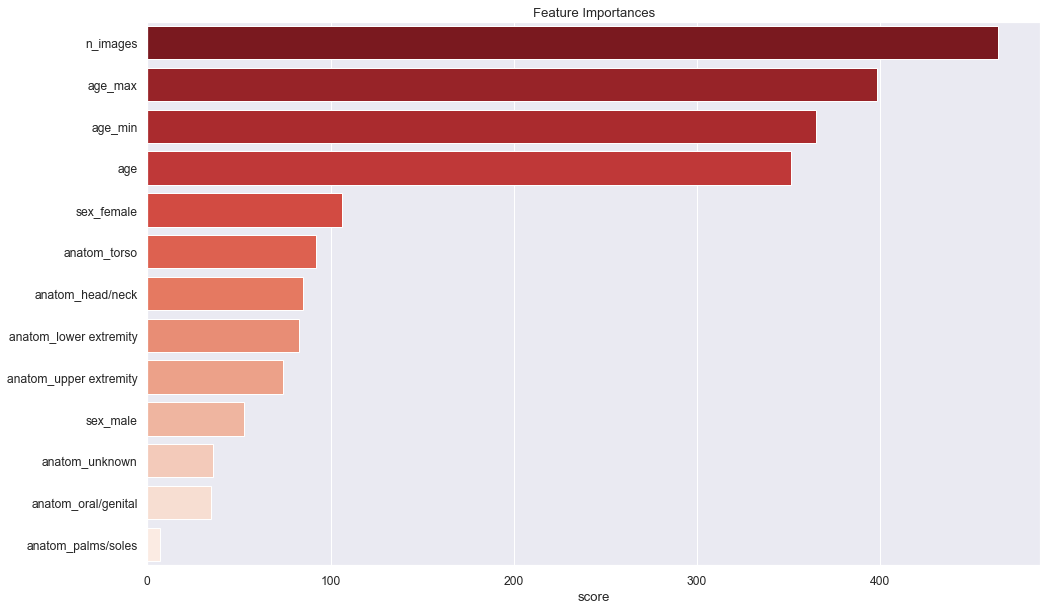

In [282]:
# finding feature importances and creating new dataframe basen on them

feature_importance = xg.get_booster().get_score(importance_type='weight')

keys = list(feature_importance.keys())
values = list(feature_importance.values())

importance = pd.DataFrame(data=values, index=keys,
                          columns=['score']).sort_values(by='score',
                                                         ascending=False)
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(x=importance.score.iloc[:20],
            y=importance.index[:20],
            orient='h',
            palette='Reds_r')
ax.set_title('Feature Importances')
plt.show()

# Creating Meta Submission


In [283]:
# predicting on test set

predictions = xg.predict_proba(test)[:, 1]

In [284]:
# creating submission df

meta_df = pd.DataFrame(columns=['image_name', 'target'])

# assigning predictions on submission df

meta_df['image_name'] = sample['image_name']
meta_df['target'] = predictions

In [285]:
meta_df.to_csv('meta_with_img_data.csv', header=True, index=False)

In [286]:
meta_df

,image_name,target
0,ISIC_0052060,0.007317
1,ISIC_0052349,0.004840
2,ISIC_0058510,0.007181
3,ISIC_0073313,0.005087
4,ISIC_0073502,0.013293
...,...,...
10977,ISIC_9992485,0.018545
10978,ISIC_9996992,0.004078
10979,ISIC_9997917,0.023927
10980,ISIC_9998234,0.013584


In [287]:
meta_df.describe()

,target
count,10982.000000
mean,0.016999
std,0.024777
min,0.002198
25%,0.006237
50%,0.010334
75%,0.017439
max,0.494504
